<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/5.%20Measurement%20Induced%20Dephasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Environment Setting



In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 70.2 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit

# shelter

In [ ]:
corr1 = correlation_2op_1t(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    readout_number_dressed,
    readout_number_dressed,
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd}
)

In [ ]:
corr2 = correlation_2op_1t(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    sp_dressed,
    sp_dressed.dag(),
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd}
)

# CP CPMG UDD XY4 XY8 XY16 Sequence

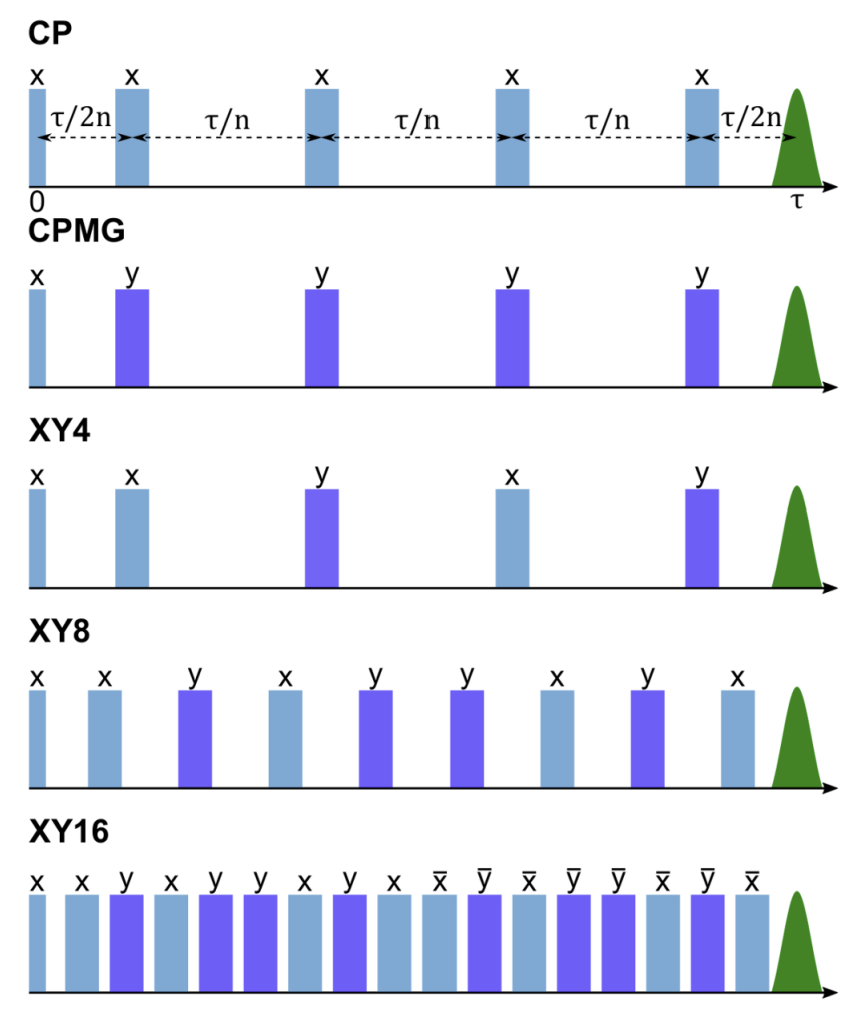

In [3]:
# Modulate each pulse timing (Equivalent Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []
    for i in range(N):
      Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq


# Modulate each pulse timing (Sinusoidal Spacing)
# pulse list
# skip pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing_UDD(T_srt, T_end, N):

    T = T_end - T_srt
    Seq_list = []

    shift = 0
    for i in range(N):
      shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
      Seq_list.append(T_srt + shift)

    Seq = np.array(Seq_list)

    return Seq

In [4]:
# Single Square Pulse Envolope

def Single_pulse_env(t, B, T_cent):

    return B * (t > T_cent-0.5*np.pi/B) * (t < T_cent+0.5*np.pi/B)


# Single Square Pulse (lab frame)

def Single_pulse(t, B, Omega_qd, T_cent, Phi_qd):

    return Single_pulse_env(t, B, T_cent) * np.cos(Omega_qd * t + Phi_qd)

In [5]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T_srt = args['T_srt_r'] # duration of the readout drive, in units of ns
    T_end = args['T_end_r'] # duration of the readout drive, in units of ns

    return A * (T_srt <= t) * (t <= T_end)


def Hrd_lab_frame(t, args):
    omega_rd = args['Omega_rd']
    return Hrd_rotating_frame(t, args) * np.cos(omega_rd * t)

## CP CPMG UDD Sequence

In [6]:
# CP (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CP_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0)

    return pulse

In [7]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def CPMG_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

In [8]:
# CPMG (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N_seq (number of pulse)

def UDD_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    N = args['N_seq']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, N)
    pulse = 0

    for T_cent in Seq:
      pulse = pulse + Single_pulse(t, B, Omega_qd, T_cent, 0.5*np.pi)

    return pulse

## XY4 XY8 XY16 Sequence

In [9]:
# XY4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [10]:
# XY8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [11]:
# XY16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def XY16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

## UDD4 UDD8 UDD16 Sequence

In [12]:
# UDD4 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD4_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 4)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    return pulse

In [13]:
# UDD8 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD8_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 8)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    return pulse

In [14]:
# UDD16 (lab frame)

# args

# B (qubit drive amplitude)
# Omega_qd (qubit drive frequency)
# T_srt (pulse start time)
# T_end (pulse end time)

def UDD16_lab_frame(t, args):

    Omega_qd = args['Omega_qd']
    T_srt = args['T_srt_q']
    T_end = args['T_end_q']
    B = args['B']

    # T_cent
    Seq = Pulse_Timing_UDD(T_srt, T_end, 16)
    pulse = 0

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[0], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[1], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[2], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[3], 0.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[4], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[5], 0)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[6], 0.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[7], 0)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[8], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[9], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[10], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[11], 1.5*np.pi)

    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[12], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[13], np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[14], 1.5*np.pi)
    pulse = pulse + Single_pulse(t, B, Omega_qd, Seq[15], np.pi)

    return pulse

# Effective Linewidth & Photon Number & Ring-up Oscillation Frequency Simulation

In [219]:
rkappa_simulation = []
pkappa_simulation = []

rphoton_simulation = []
pphoton_simulation = []

roscillation_simulation = []
poscillation_simulation = []

## $G=2\pi 10MHz$

In [220]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.01 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.010        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [221]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [222]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [223]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

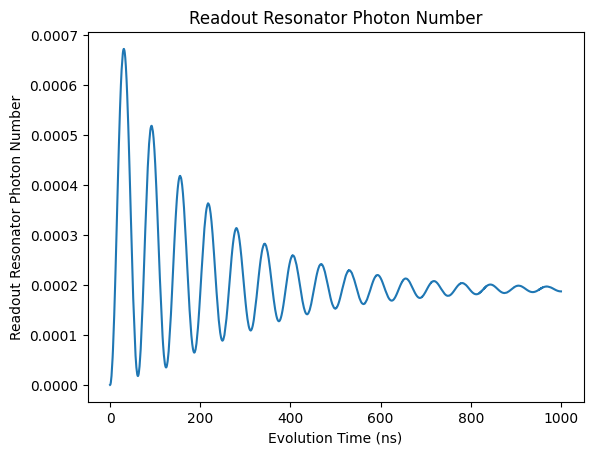

In [224]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

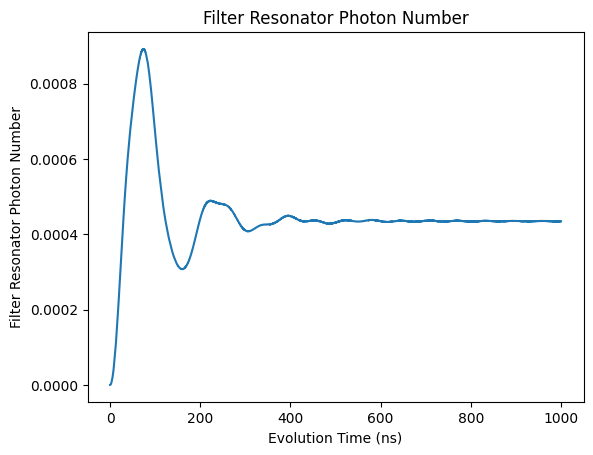

In [225]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [226]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([0.00019129, 0.0160317 , 0.00910691])

In [227]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [228]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([0.00043514, 0.00622535, 0.02291744])

In [229]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 10MHz$

In [230]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

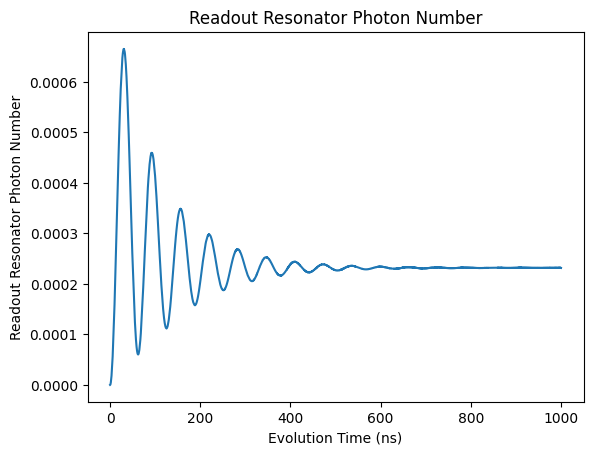

In [231]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

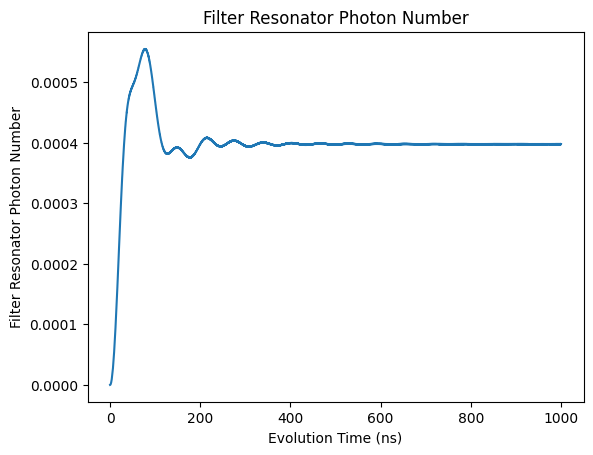

In [232]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [233]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([0.00022977, 0.01588566, 0.01942506])

In [234]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [235]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([0.00039849, 0.00622941, 0.04789414])

In [236]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 15MHz$

In [237]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

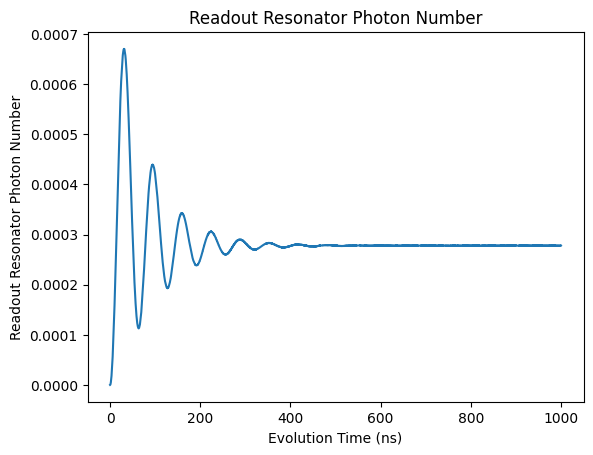

In [238]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

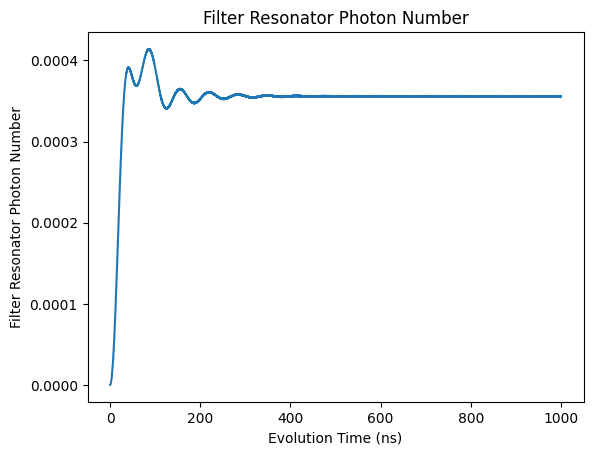

In [239]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [240]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([0.0002758 , 0.01544541, 0.03225488])

In [241]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [242]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([0.0003565 , 0.00659083, 0.0872088 ])

In [243]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 20MHz$

In [244]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

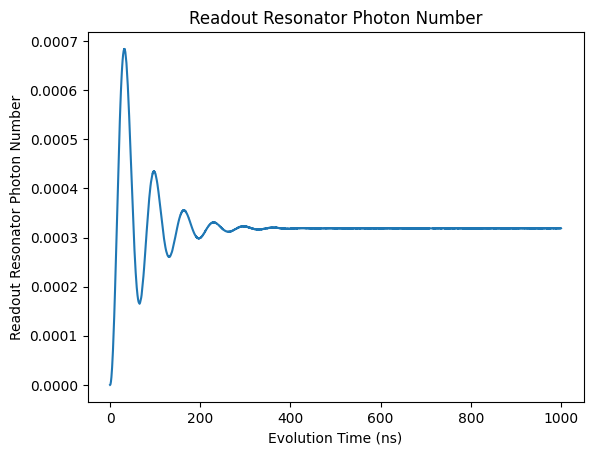

In [245]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

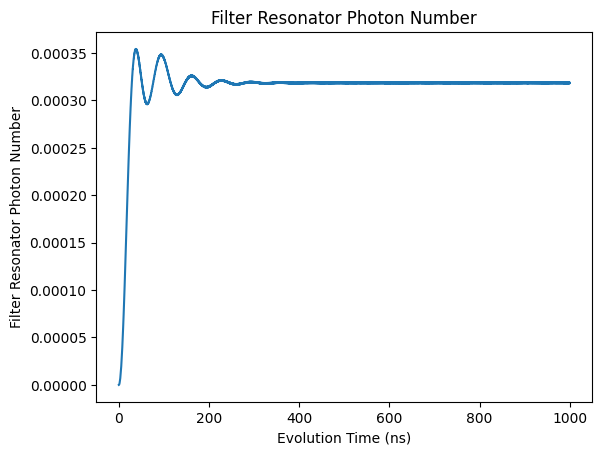

In [246]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [247]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([0.00031699, 0.01474919, 0.04394341])

In [248]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [249]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([0.00031842, 0.00697467, 0.11921894])

In [250]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 25MHz$

In [251]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

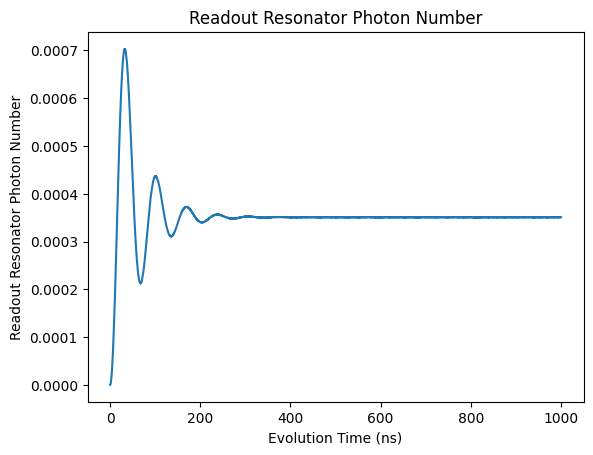

In [252]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

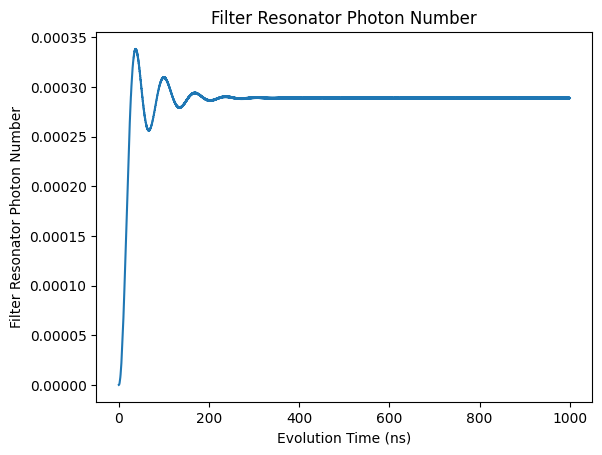

In [253]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [254]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([0.00034953, 0.01399121, 0.05072254])

In [255]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [256]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([0.00028835, 0.00812419, 0.12104355])

In [257]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 30MHz$

In [258]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

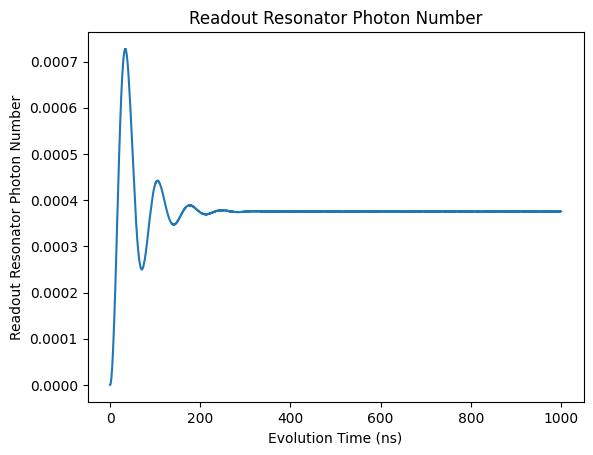

In [259]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

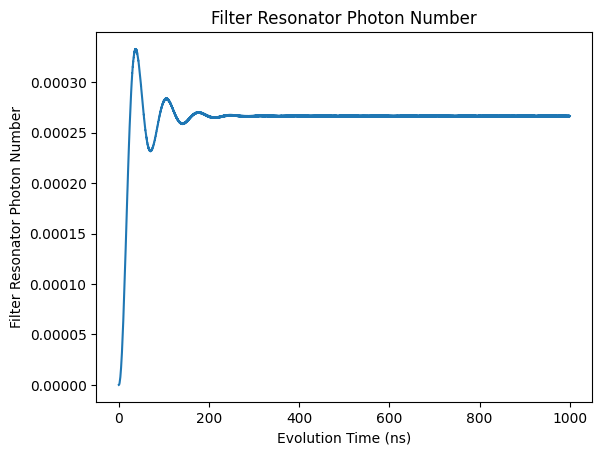

In [260]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [261]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([0.00037428, 0.01328767, 0.05305225])

In [262]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [263]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([0.00026575, 0.00934871, 0.10905271])

In [264]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

## $G=2\pi 20MHz$

In [265]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.01 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.020        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [266]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [267]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [268]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

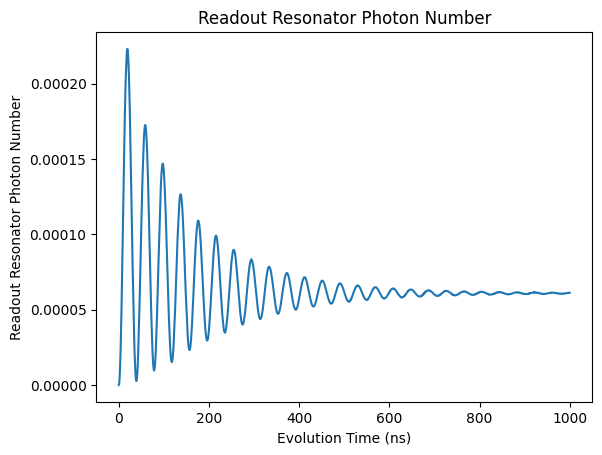

In [269]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

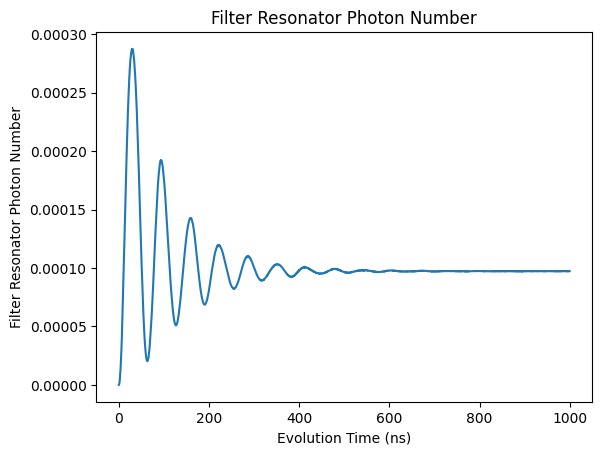

In [270]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [271]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([6.09307246e-05, 2.54957241e-02, 1.21309883e-02])

In [272]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [273]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([9.73500799e-05, 1.56837924e-02, 1.96715077e-02])

In [274]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 10MHz$

In [275]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

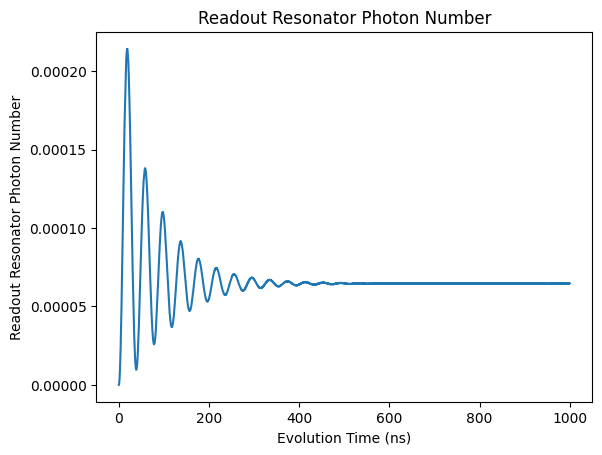

In [276]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

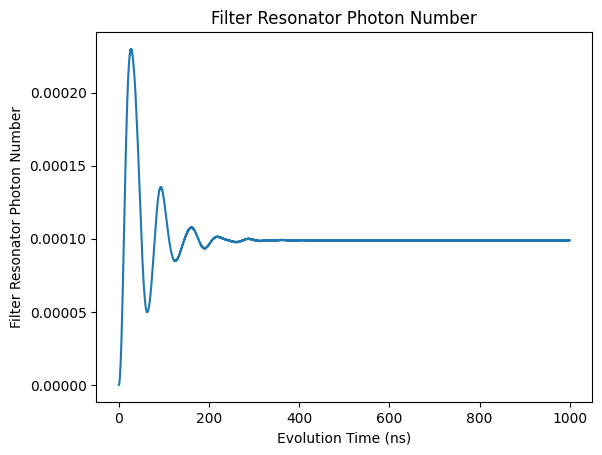

In [277]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [278]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([6.47143029e-05, 2.54676744e-02, 2.46622107e-02])

In [279]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [280]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([9.90271905e-05, 1.56689170e-02, 3.99249822e-02])

In [281]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 15MHz$

In [282]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

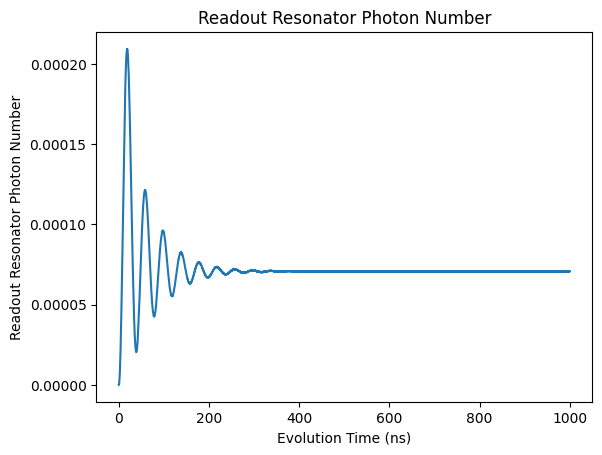

In [283]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

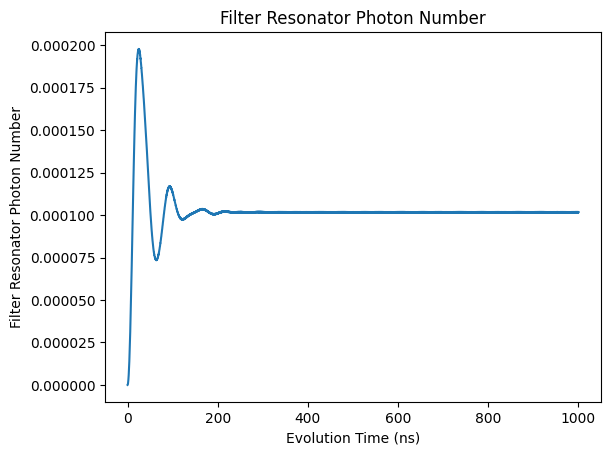

In [284]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [285]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([7.07765667e-05, 2.53442615e-02, 3.76396128e-02])

In [286]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [287]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([0.00010177, 0.01571798, 0.06139954])

In [288]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 20MHz$

In [289]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

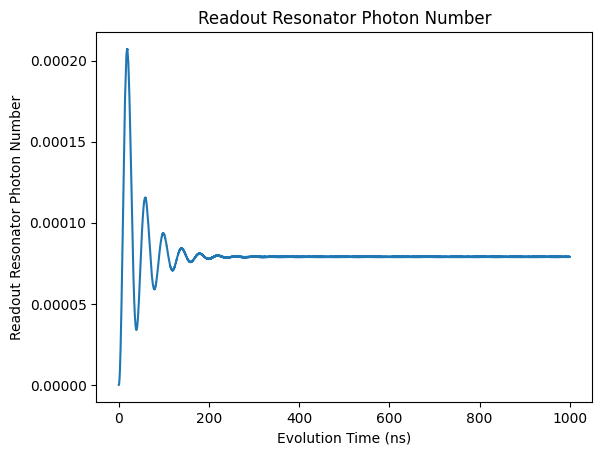

In [290]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

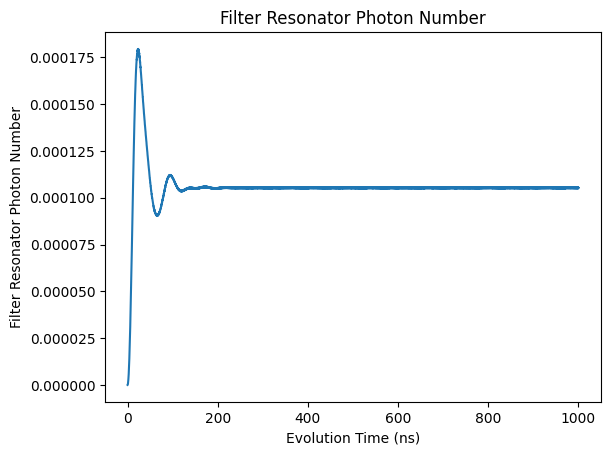

In [291]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [292]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([7.89283251e-05, 2.50340017e-02, 5.15767925e-02])

In [293]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [294]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([0.00010541, 0.01596126, 0.08445513])

In [295]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 25MHz$

In [296]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

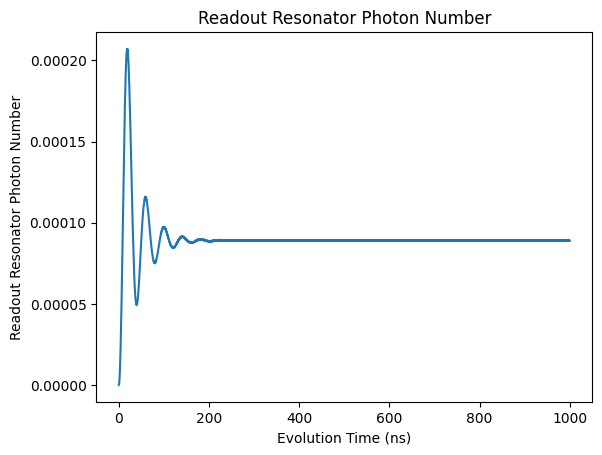

In [297]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

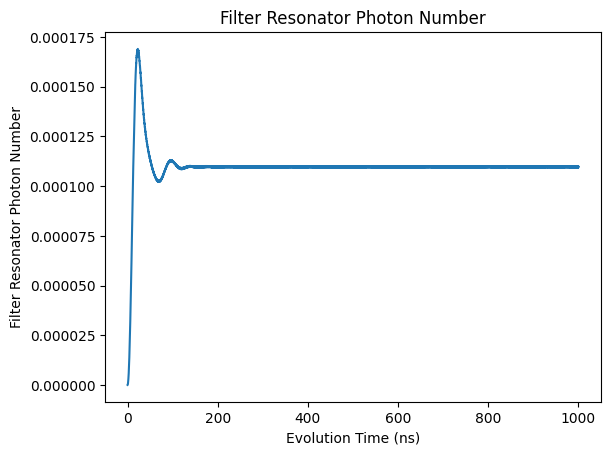

In [298]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [299]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([8.88838246e-05, 2.44677084e-02, 6.70020119e-02])

In [300]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [301]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([0.00010979, 0.0162883 , 0.10834457])

In [302]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 30MHz$

In [303]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

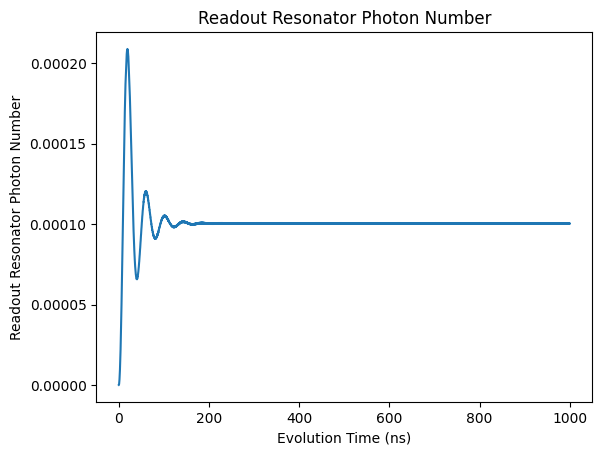

In [304]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

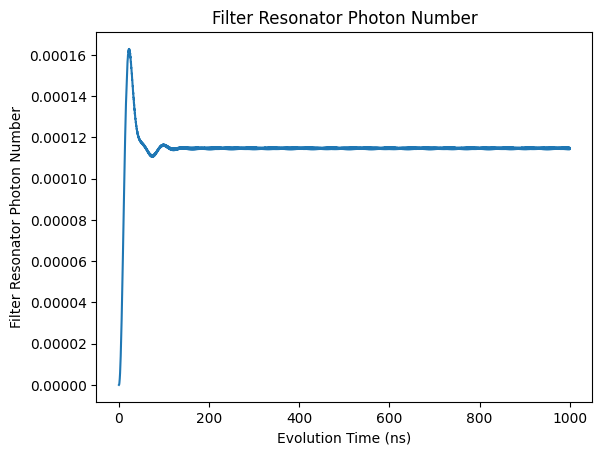

In [305]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [306]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([0.00010027, 0.0236396 , 0.08333188])

In [307]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [308]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([1.14744984e-04, 1.63158828e-02, 1.29972827e-01])

In [309]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

## $G=2\pi 30MHz$

In [310]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.01 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.030        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [311]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [312]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [313]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

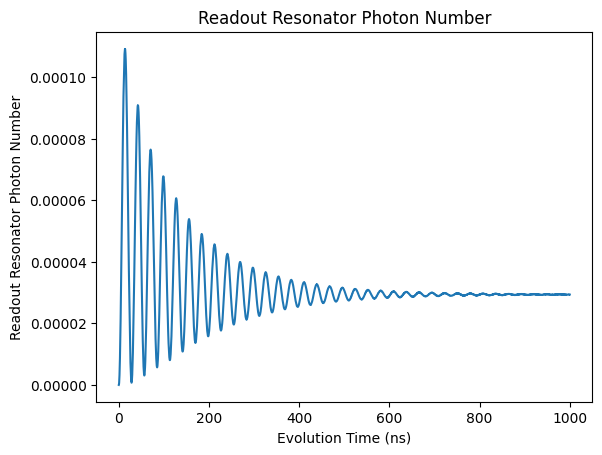

In [314]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

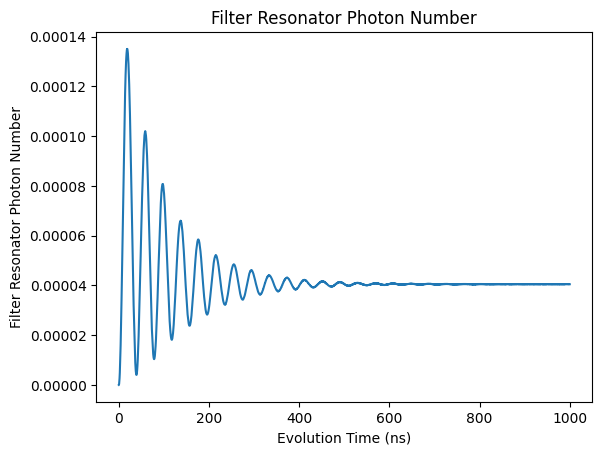

In [315]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [316]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([2.94368297e-05, 3.53042648e-02, 1.33261004e-02])

In [317]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [318]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([4.05291308e-05, 2.54877124e-02, 1.85085758e-02])

In [319]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 10MHz$

In [320]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

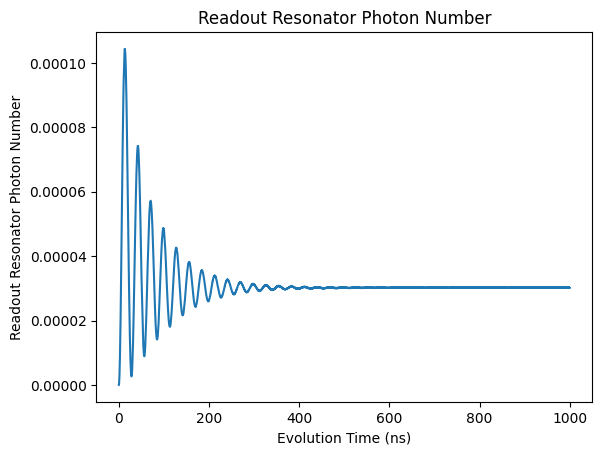

In [321]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

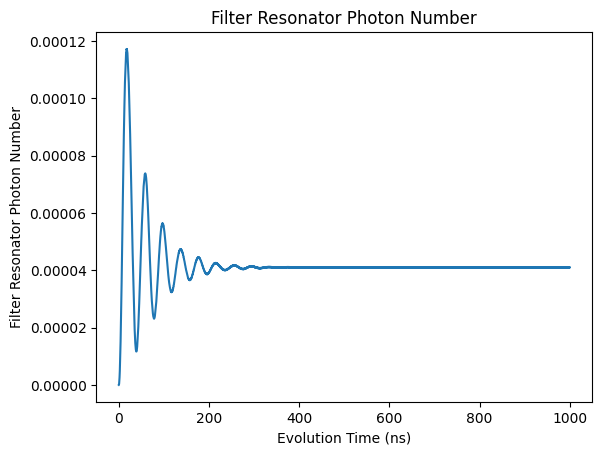

In [322]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [323]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([3.02068221e-05, 3.52921277e-02, 2.67509236e-02])

In [324]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [325]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([4.10268776e-05, 2.54770474e-02, 3.71948436e-02])

In [326]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 15MHz$

In [327]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

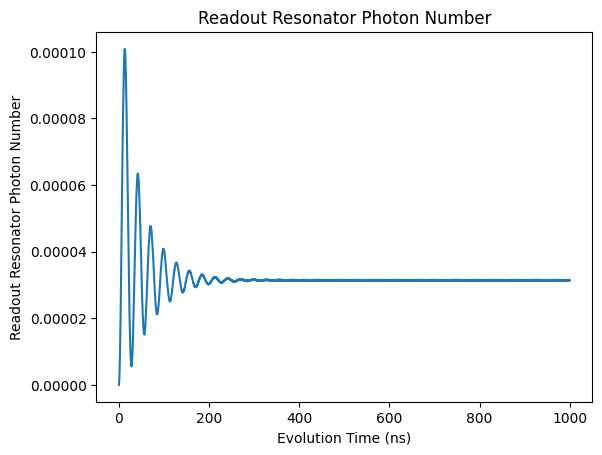

In [328]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

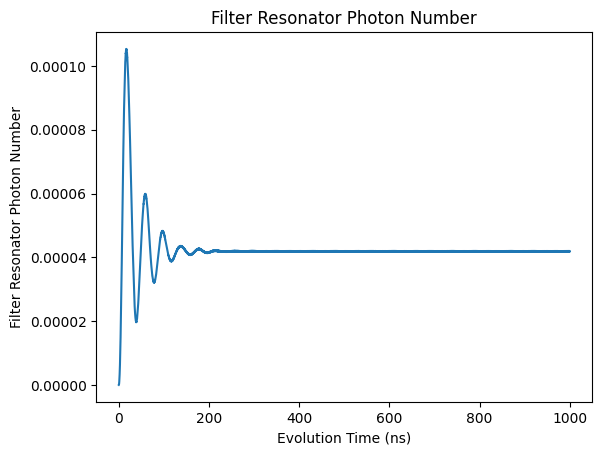

In [329]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [330]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([3.14801210e-05, 3.52489830e-02, 4.03096869e-02])

In [331]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [332]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([4.18974595e-05, 2.54962110e-02, 5.68360435e-02])

In [333]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 20MHz$

In [334]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

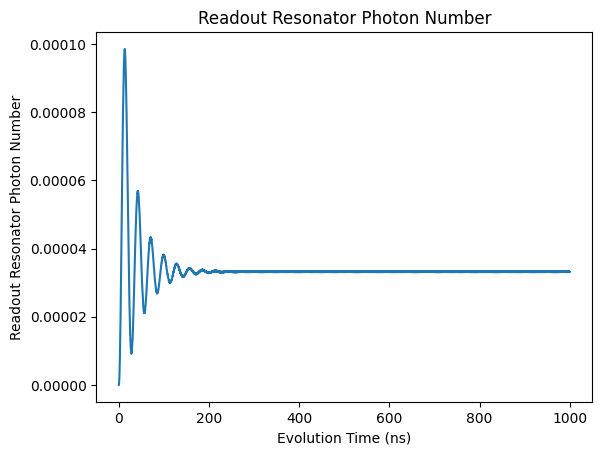

In [335]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

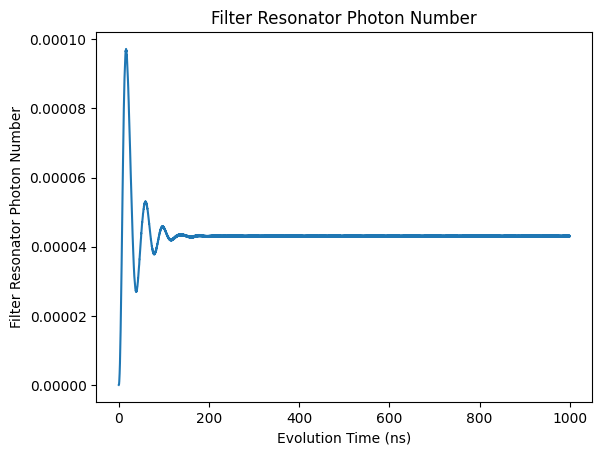

In [336]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [337]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([3.32407649e-05, 3.51472094e-02, 5.39272029e-02])

In [338]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [339]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([4.30917296e-05, 2.56182816e-02, 7.70038295e-02])

In [340]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 25MHz$

In [341]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

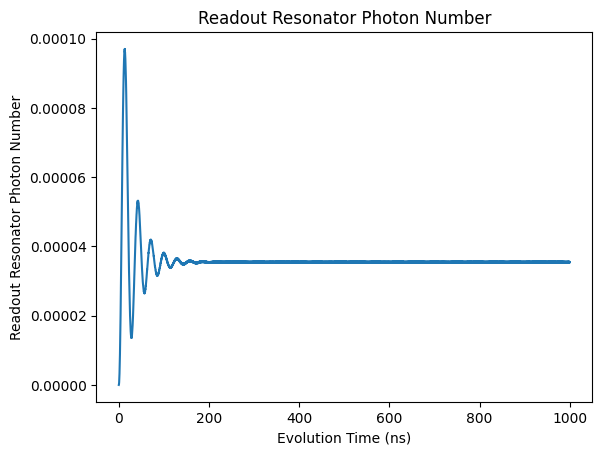

In [342]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

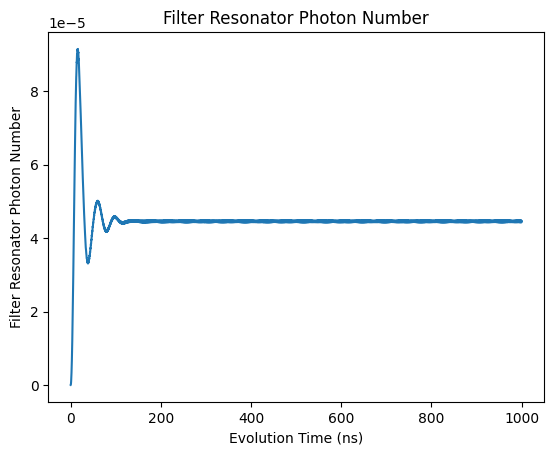

In [343]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [344]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([3.54801193e-05, 3.49455822e-02, 6.78118093e-02])

In [345]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [346]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([4.45963310e-05, 2.58521301e-02, 9.72343970e-02])

In [347]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 30MHz$

In [348]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

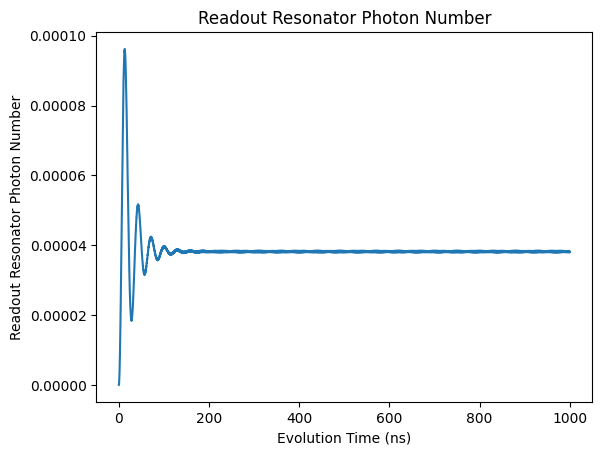

In [349]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

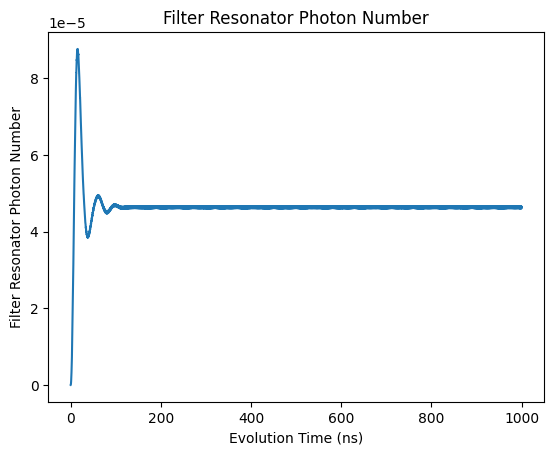

In [350]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [351]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([3.81839996e-05, 3.45984140e-02, 8.23163741e-02])

In [352]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [353]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([4.64018724e-05, 2.60954311e-02, 1.17216479e-01])

In [354]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

## $G=2\pi 40MHz$

In [355]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.01 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.040        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [356]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [357]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [358]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

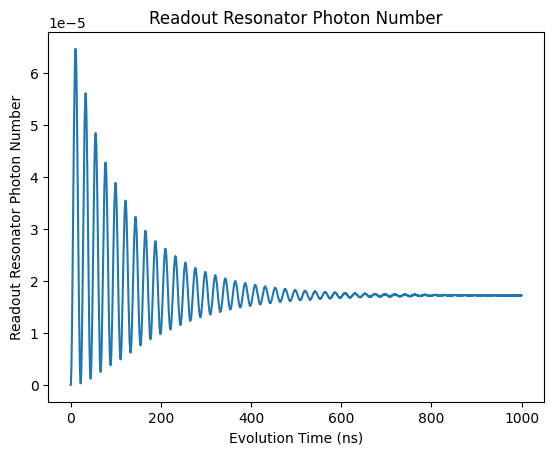

In [359]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

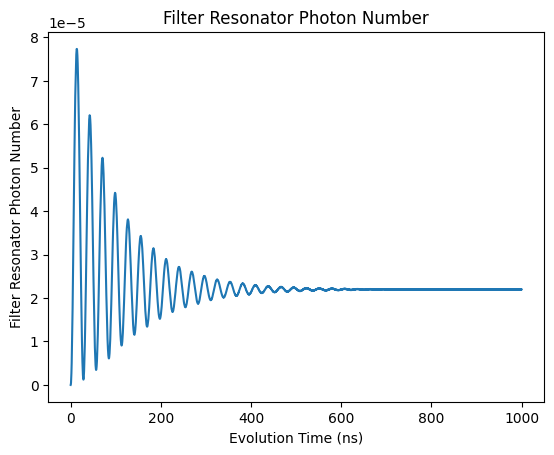

In [360]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [361]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.72745529e-05, 4.52089610e-02, 1.40113124e-02])

In [362]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [363]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([2.19988328e-05, 3.53857264e-02, 1.79988092e-02])

In [364]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 10MHz$

In [365]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

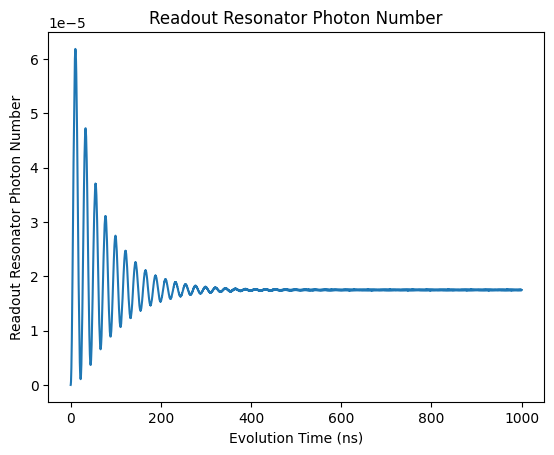

In [366]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

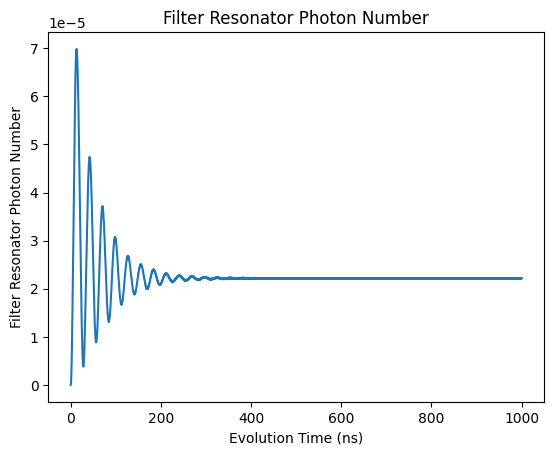

In [367]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [368]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.75079141e-05, 4.52021703e-02, 2.78822539e-02])

In [369]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [370]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([2.21607195e-05, 3.53754176e-02, 3.58002686e-02])

In [371]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 15MHz$

In [372]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

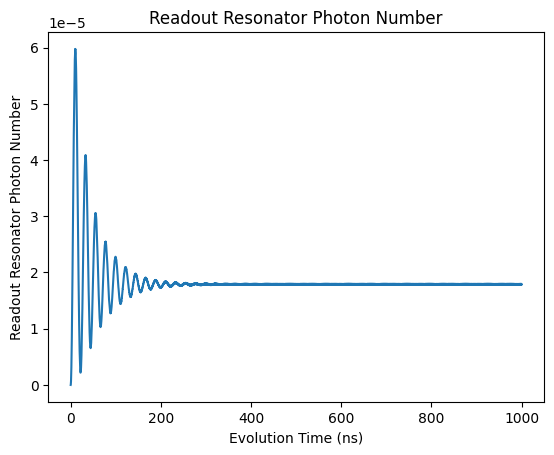

In [373]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

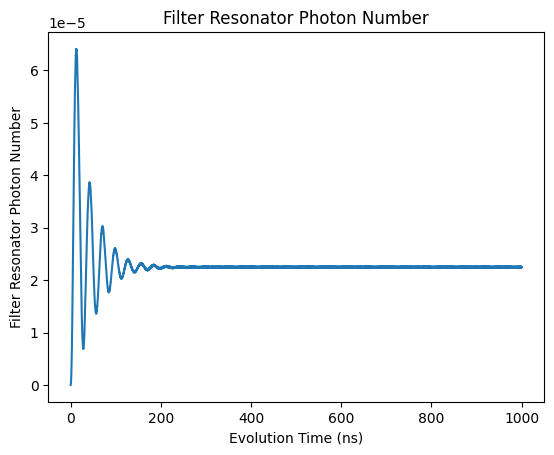

In [374]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [375]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.79124535e-05, 4.51816658e-02, 4.18338793e-02])

In [376]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [377]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([2.24753480e-05, 3.53821942e-02, 5.44370680e-02])

In [378]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 20MHz$

In [379]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

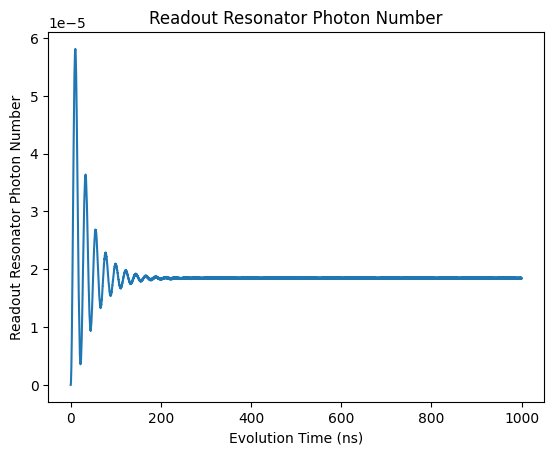

In [380]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

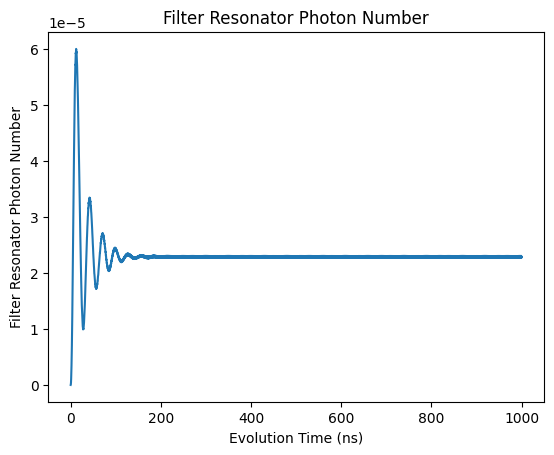

In [381]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [382]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.84761796e-05, 4.51424986e-02, 5.57477029e-02])

In [383]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [384]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([2.29123538e-05, 3.54569410e-02, 7.36347592e-02])

In [385]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 25MHz$

In [386]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

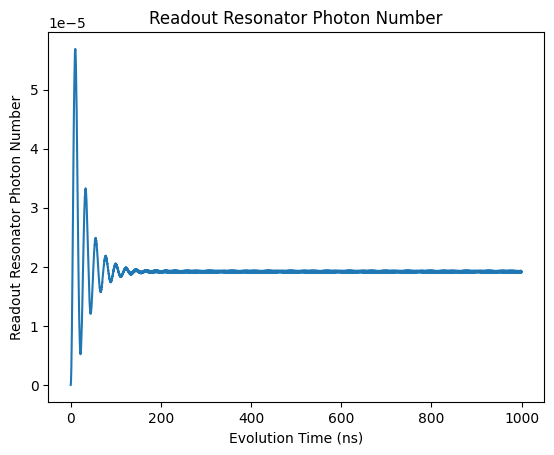

In [387]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

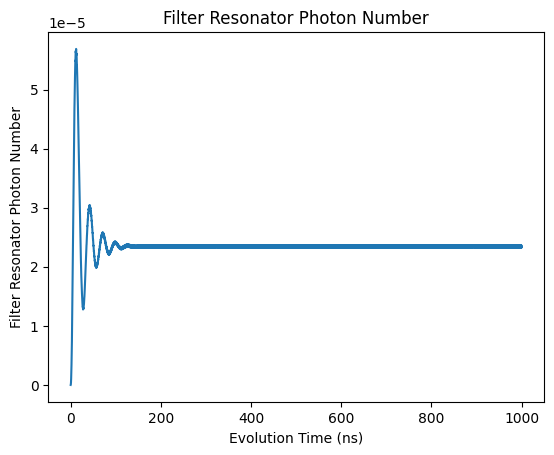

In [388]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [389]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.91981487e-05, 4.50699140e-02, 6.96520589e-02])

In [390]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [391]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([2.34659057e-05, 3.56219621e-02, 9.28224119e-02])

In [392]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 30MHz$

In [393]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

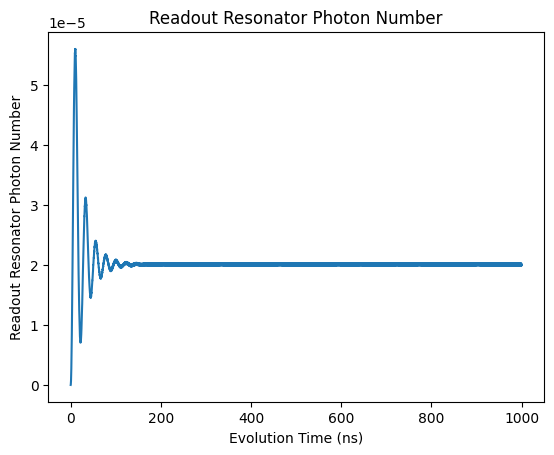

In [394]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

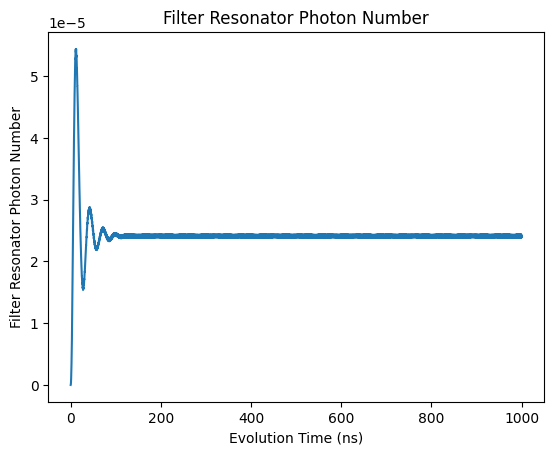

In [395]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [396]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([2.00772725e-05, 4.49378218e-02, 8.36738095e-02])

In [397]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [398]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([2.41354779e-05, 3.58449505e-02, 1.11664962e-01])

In [399]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

## $G=2\pi 50MHz$

In [400]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.01 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.050        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [401]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [402]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [403]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

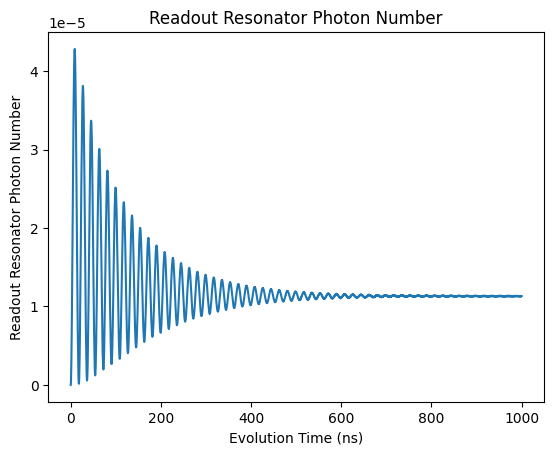

In [404]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

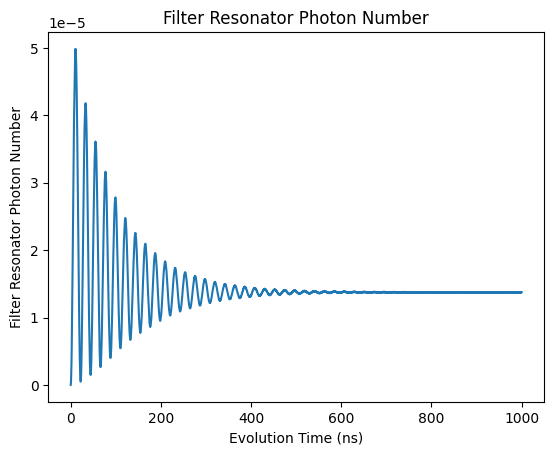

In [405]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [406]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.13439865e-05, 5.51536440e-02, 1.44976400e-02])

In [407]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [408]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([1.37740198e-05, 4.53216464e-02, 1.77781350e-02])

In [409]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 10MHz$

In [410]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

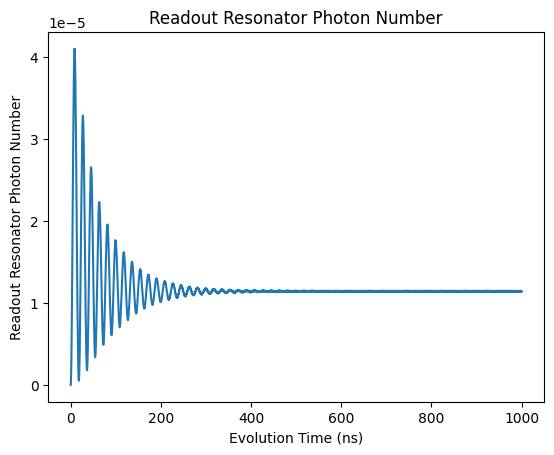

In [411]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

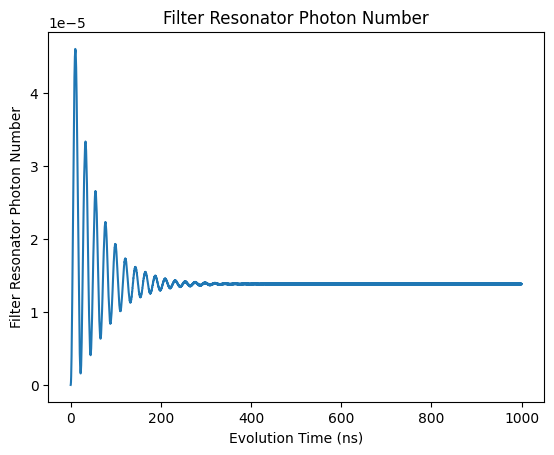

In [412]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [413]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.14291338e-05, 5.51503342e-02, 2.86179290e-02])

In [414]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [415]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([1.38305224e-05, 4.53105285e-02, 3.50049005e-02])

In [416]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 15MHz$

In [417]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

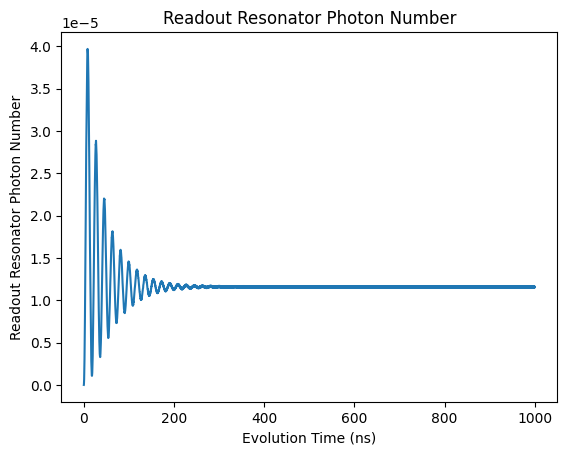

In [418]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

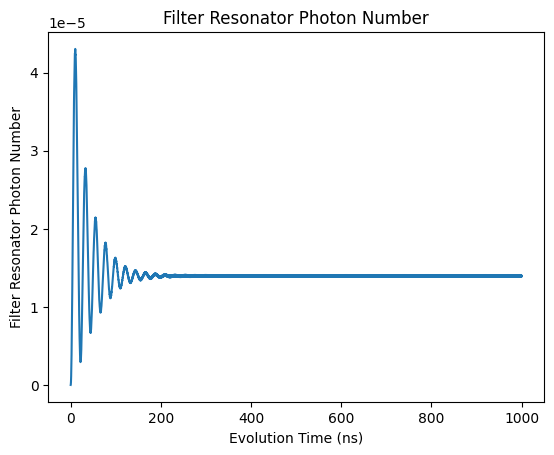

In [419]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [420]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.15932517e-05, 5.51404490e-02, 4.28213497e-02])

In [421]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [422]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([1.39664683e-05, 4.53088332e-02, 5.29677972e-02])

In [423]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 20MHz$

In [424]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

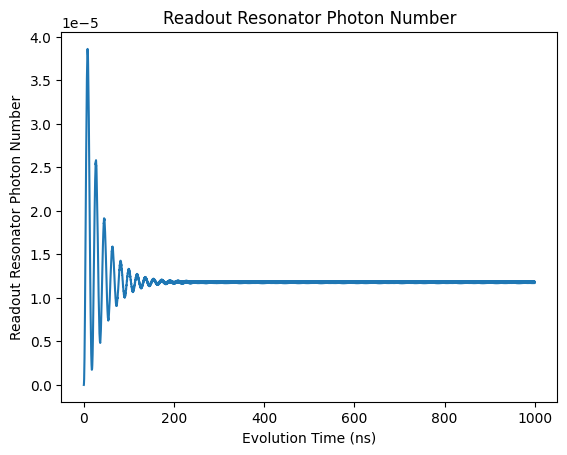

In [425]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

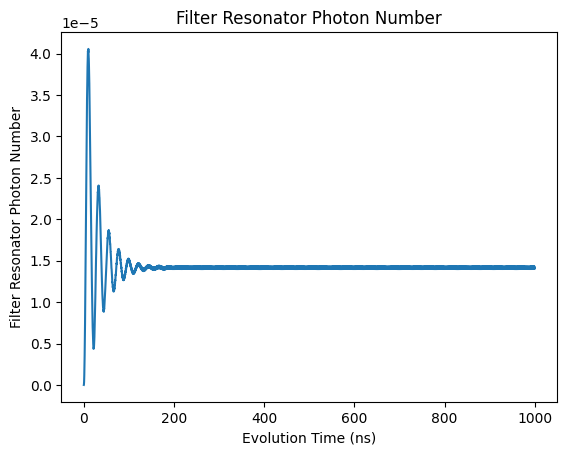

In [426]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [427]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.18237122e-05, 5.51264558e-02, 5.69783834e-02])

In [428]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [429]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([1.41578705e-05, 4.53547336e-02, 7.14901346e-02])

In [430]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 25MHz$

In [431]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

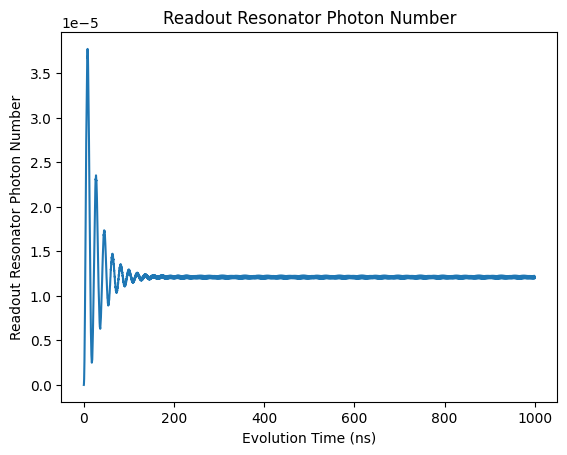

In [432]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

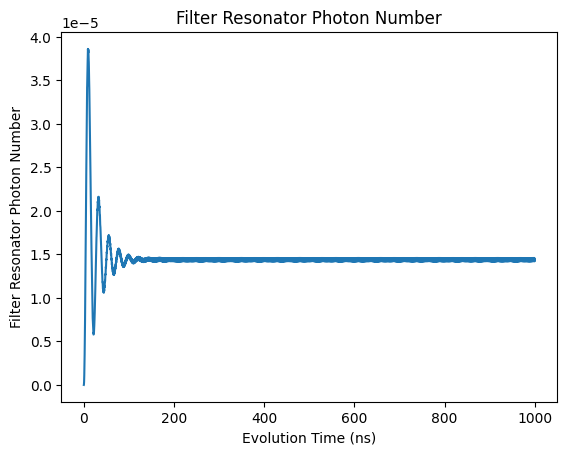

In [433]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [434]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.21198487e-05, 5.51048388e-02, 7.10955980e-02])

In [435]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [436]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([1.44010576e-05, 4.54704057e-02, 9.01423196e-02])

In [437]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 30MHz$

In [438]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

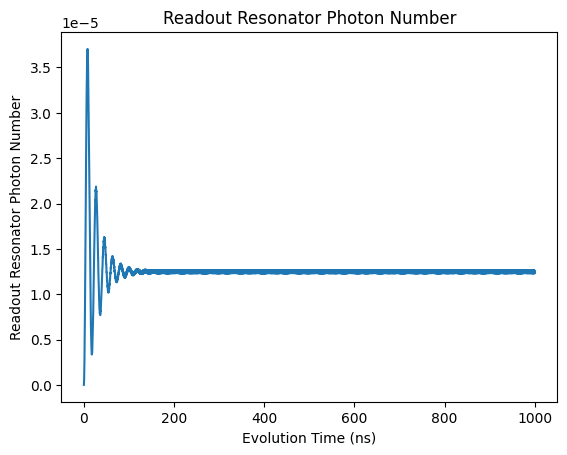

In [439]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

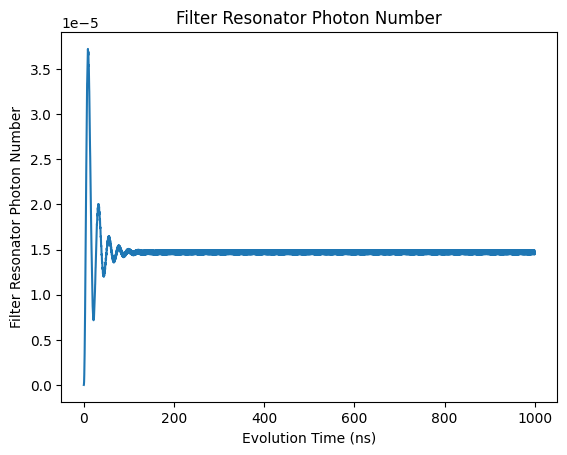

In [440]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [441]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([1.24813912e-05, 5.50626507e-02, 8.52213661e-02])

In [442]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [443]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([1.46955074e-05, 4.56462870e-02, 1.08536138e-01])

In [444]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

## $G=2\pi 60MHz$

In [445]:
# readout resonator & purcell filter resonator dimension

N = 3


# constant

B = 0.01 * 2 * np.pi        # gate operation time : 50ns

omega_r = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_f = 2 * np.pi * 7.0   # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0   # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1         # qubit-resonator coupling in units of GHz
G = 2 * np.pi * 0.060        # qubit-resonator coupling in units of GHz


detune = omega_q-omega_r
chi = g*g/(detune)

omega_rd = omega_r          # qubit frequency in units of GHz
omega_qd = omega_q + chi

# operator defined on bare basis

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)
b = destroy(N)

sx_bare                 = tensor(sx, qeye(N), qeye(N))
sy_bare                 = tensor(sy, qeye(N), qeye(N))
sz_bare                 = tensor(sz, qeye(N), qeye(N))
sp_bare                 = tensor(sp, qeye(N), qeye(N))
sm_bare                 = tensor(sm, qeye(N), qeye(N))

readout_annihilate_bare = tensor(qeye(2), a, qeye(N))
readout_create_bare     = tensor(qeye(2), a.dag(), qeye(N))
readout_number_bare     = tensor(qeye(2), a.dag()*a, qeye(N))

filter_annihilate_bare  = tensor(qeye(2), qeye(N), b)
filter_create_bare      = tensor(qeye(2), qeye(N), b.dag())
filter_number_bare      = tensor(qeye(2), qeye(N), b.dag()*b)

psi0_bare               = tensor(basis(2,0), basis(N,0), basis(N,0))
psis_bare               = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0), basis(N,0))
psi1_bare               = tensor(basis(2,1), basis(N,0), basis(N,0))


H0 = -0.5*omega_q*sz_bare + omega_r*readout_number_bare + omega_f*filter_number_bare + g*(tensor(sp, a, qeye(N))+tensor(sm, a.dag(), qeye(N))) + G*(tensor(qeye(2), a, b.dag()) + tensor(qeye(2), a.dag(), b))
H1 = tensor(qeye(2), a+a.dag(), qeye(N))
H2 = sx_bare

In [446]:
sx_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sy_dressed = + (-1j)*H0.eigenstates()[1][0]*H0.eigenstates()[1][1].dag() + (-1j)*H0.eigenstates()[1][2]*H0.eigenstates()[1][5].dag() \
+ (-1j)*H0.eigenstates()[1][3]*H0.eigenstates()[1][4].dag() + (-1j)*H0.eigenstates()[1][6]*H0.eigenstates()[1][10].dag() \
+ (-1j)*H0.eigenstates()[1][7]*H0.eigenstates()[1][9].dag() + (-1j)*H0.eigenstates()[1][8]*H0.eigenstates()[1][11].dag() \
+ (-1j)*H0.eigenstates()[1][12]*H0.eigenstates()[1][15].dag() + (-1j)*H0.eigenstates()[1][13]*H0.eigenstates()[1][14].dag() \
+ (-1j)*H0.eigenstates()[1][16]*H0.eigenstates()[1][17].dag() \
+ (+1j)*H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + (+1j)*H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ (+1j)*H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + (+1j)*H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ (+1j)*H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + (+1j)*H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ (+1j)*H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + (+1j)*H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ (+1j)*H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


sz_dressed = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() \
- H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag() - H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
- H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() - H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
- H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() - H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
- H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() - H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
- H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()


sp_dressed = H0.eigenstates()[1][1]*H0.eigenstates()[1][0].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][2].dag() \
+ H0.eigenstates()[1][4]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][10]*H0.eigenstates()[1][6].dag() \
+ H0.eigenstates()[1][9]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][11]*H0.eigenstates()[1][8].dag() \
+ H0.eigenstates()[1][15]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][13].dag() \
+ H0.eigenstates()[1][17]*H0.eigenstates()[1][16].dag()


readout_number_dressed = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag() + H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag() + 2*H0.eigenstates()[1][11]*H0.eigenstates()[1][11].dag() \
+ 2*H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + 2*H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag() \


filter_number_dressed = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag() + H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag() \
+ H0.eigenstates()[1][7]*H0.eigenstates()[1][7].dag() + H0.eigenstates()[1][9]*H0.eigenstates()[1][9].dag() \
+ H0.eigenstates()[1][13]*H0.eigenstates()[1][13].dag() + H0.eigenstates()[1][15]*H0.eigenstates()[1][15].dag() \
+ 2*H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag() + 2*H0.eigenstates()[1][10]*H0.eigenstates()[1][10].dag() \
+ 2*H0.eigenstates()[1][12]*H0.eigenstates()[1][12].dag() + 2*H0.eigenstates()[1][14]*H0.eigenstates()[1][14].dag() \
+ 2*H0.eigenstates()[1][16]*H0.eigenstates()[1][16].dag() + 2*H0.eigenstates()[1][17]*H0.eigenstates()[1][17].dag()

In [447]:
psi0_dressed             = H0.eigenstates()[1][0]
psi1_dressed             = H0.eigenstates()[1][1]
psis_dressed             = (psi0_dressed + psi1_dressed)/np.sqrt(2)

op_list = [sx_dressed, sy_dressed, sz_dressed, sp_dressed, readout_number_dressed, filter_number_dressed]

### $ \kappa = 2\pi 5MHz$

In [448]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.005  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

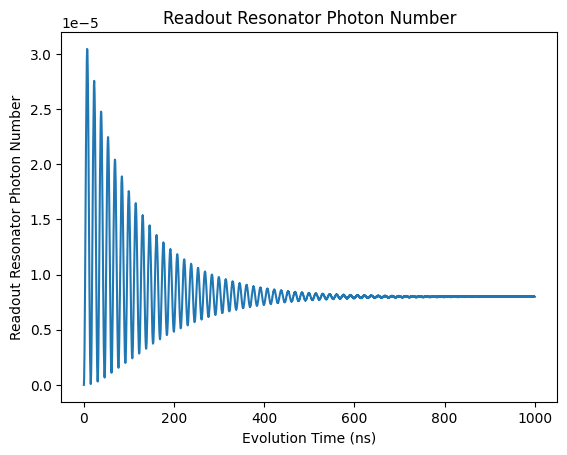

In [449]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

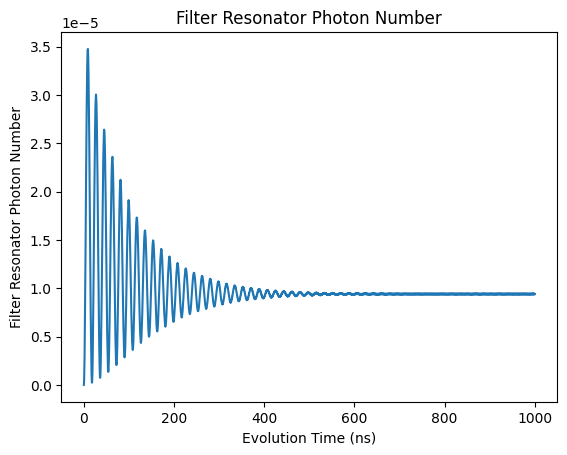

In [450]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [451]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([8.01689854e-06, 6.51189985e-02, 1.48973934e-02])

In [452]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [453]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([9.42707969e-06, 5.52761697e-02, 1.77204010e-02])

In [454]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 10MHz$

In [455]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.010  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

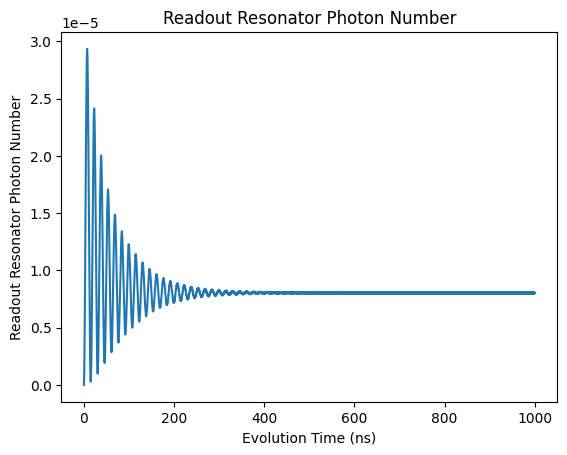

In [456]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

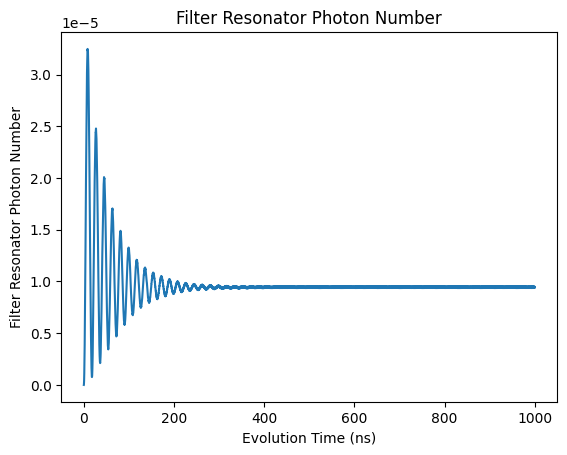

In [457]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [458]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([8.04869496e-06, 6.51187046e-02, 2.91553203e-02])

In [459]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [460]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([9.44367730e-06, 5.52635043e-02, 3.45249493e-02])

In [461]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 15MHz$

In [462]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.015  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

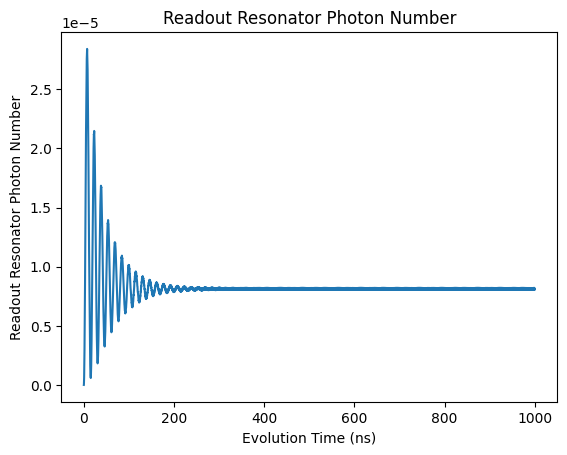

In [463]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

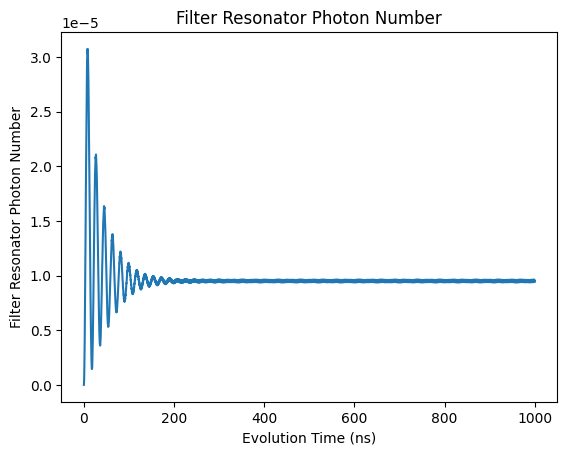

In [464]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [465]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([8.12649680e-06, 6.51159831e-02, 4.35313378e-02])

In [466]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [467]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([9.51051930e-06, 5.52549217e-02, 5.20171416e-02])

In [468]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 20MHz$

In [469]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.020  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

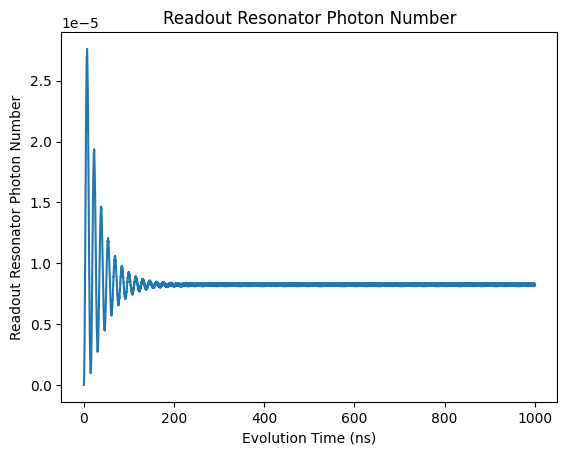

In [470]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

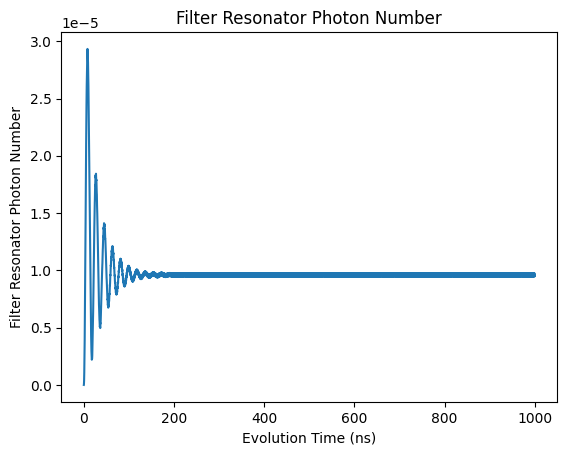

In [471]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [472]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([8.23705417e-06, 6.51158841e-02, 5.78683389e-02])

In [473]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [474]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([9.60638923e-06, 5.52802556e-02, 7.00218015e-02])

In [475]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 25MHz$

In [476]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.025  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

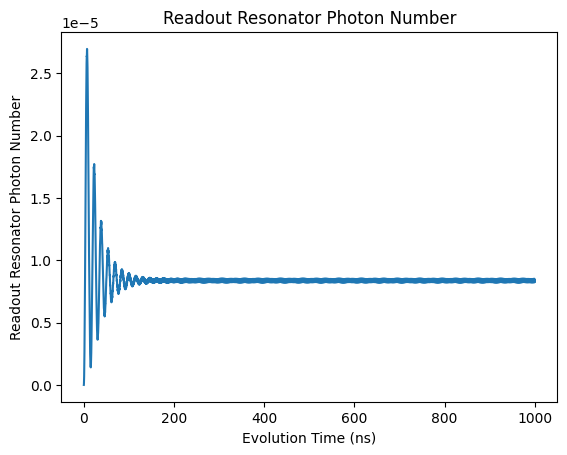

In [477]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

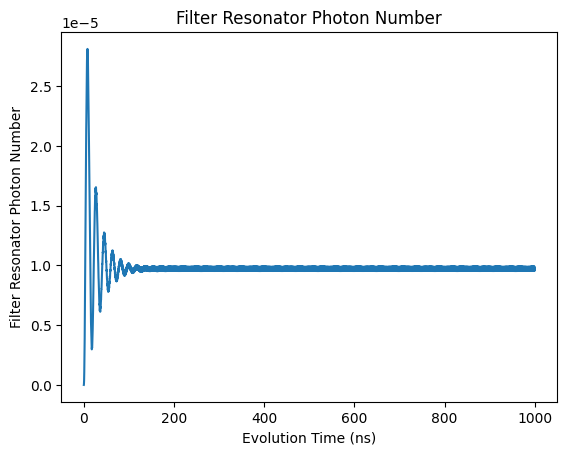

In [478]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [479]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([8.37957899e-06, 6.51194755e-02, 7.21716953e-02])

In [480]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [481]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([9.72865676e-06, 5.53591525e-02, 8.82371770e-02])

In [482]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

### $ \kappa = 2\pi 30MHz$

In [483]:
# Simulation

N_seq = 0
A = 0.0005 * 2 * np.pi
omega_qd = 37.6381
kappa_f = 2 * np.pi * 0.030  # external coupling rate of resonator in units of GHz

tlist = np.linspace(0, 1000, 10000)

result = mesolve(
    [H0, [H1, Hrd_lab_frame], [H2, CP_lab_frame]],
    psis_dressed,
    tlist,
    c_ops = [np.sqrt(kappa_f) * tensor(qeye(2), qeye(N), b)],
    args = {'A': A, 'T_srt_r': 0, 'T_end_r': 50000, 'Omega_rd': omega_rd, 'B': B, 'T_srt_q': 0, 'T_end_q': 400, 'N_seq': N_seq, 'Omega_qd': omega_qd},
    e_ops = op_list,
)

Text(0, 0.5, 'Readout Resonator Photon Number')

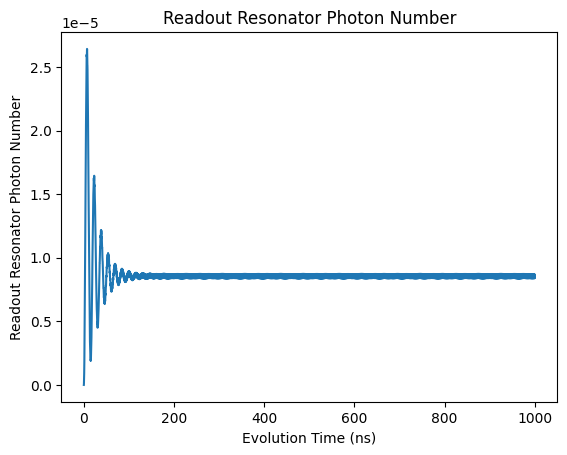

In [484]:
# Plot Results

plt.plot(tlist, result.expect[4])

plt.title('Readout Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Readout Resonator Photon Number')

Text(0, 0.5, 'Filter Resonator Photon Number')

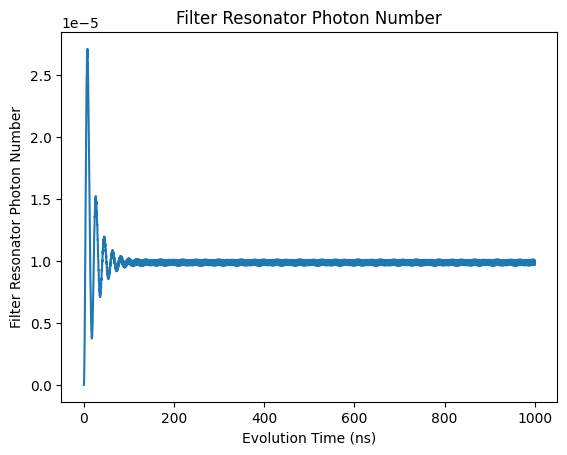

In [485]:
# Plot Results

plt.plot(tlist, result.expect[5])

plt.title('Filter Resonator Photon Number')
plt.xlabel('Evolution Time (ns)')
plt.ylabel('Filter Resonator Photon Number')

In [486]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[4], p0 = [0.02, 0.01, 0.012])

popt

array([8.55387835e-06, 6.51204774e-02, 8.64735806e-02])

In [487]:
rkappa_simulation.append(popt[2])
rphoton_simulation.append(popt[0])
roscillation_simulation.append(np.abs(popt[1]))

In [488]:
# Fitting function : exponential function

def func(t, a, b, kappa):
  return a*(1 - 2*np.exp(-kappa*t/2)*np.cos(2*np.pi*b*t) + np.exp(-kappa*t))


popt, pcov = curve_fit(func, tlist, result.expect[5], p0 = [0.02, 0.0128, 0.012])

popt

array([9.87682002e-06, 5.54902837e-02, 1.06332613e-01])

In [489]:
pkappa_simulation.append(popt[2])
pphoton_simulation.append(popt[0])
poscillation_simulation.append(np.abs(popt[1]))

## Comparison btw simulation & theory

In [490]:
print(rkappa_simulation)

[0.009106906683373425, 0.019425058587448932, 0.03225488376693228, 0.04394340518704466, 0.05072253661161993, 0.05305225271764298, 0.012130988291721077, 0.02466221074207291, 0.03763961284299791, 0.05157679253272916, 0.06700201191976048, 0.08333187572292157, 0.013326100365764629, 0.026750923607657306, 0.0403096868969057, 0.053927202925624015, 0.06781180932282602, 0.08231637409255202, 0.014011312402059285, 0.027882253949483266, 0.04183387931570109, 0.055747702885489206, 0.06965205886270066, 0.08367380950241059, 0.014497640018040029, 0.0286179290431242, 0.042821349664929884, 0.05697838336605742, 0.07109559802446246, 0.08522136614438526, 0.014897393439269513, 0.029155320270895572, 0.043531337817636614, 0.057868338884828424, 0.07217169526697838, 0.08647358057361905]


In [491]:
print(pkappa_simulation)

[0.02291743501645399, 0.04789414058757258, 0.08720879953515083, 0.1192189362610488, 0.12104355484807074, 0.10905270814229424, 0.019671507678970097, 0.03992498223137292, 0.06139954231235283, 0.08445513443308032, 0.10834457255993513, 0.1299728266641616, 0.018508575811159132, 0.03719484362057492, 0.05683604354802631, 0.0770038295276847, 0.0972343970189552, 0.11721647868307192, 0.017998809194402828, 0.035800268587248156, 0.054437067977916115, 0.07363475920869138, 0.09282241193817704, 0.11166496236445375, 0.017778135034025512, 0.03500490046261692, 0.05296779715367887, 0.07149013464963351, 0.09014231964672828, 0.10853613750201409, 0.017720400994643334, 0.03452494934197542, 0.05201714164781151, 0.07002180147699931, 0.08823717699846521, 0.10633261288237578]


In [492]:
print(rphoton_simulation)

[0.00019128522838813644, 0.00022976801504330022, 0.00027580382021493593, 0.00031698842721414533, 0.0003495258793555443, 0.00037427788388034544, 6.093072460700853e-05, 6.471430294157178e-05, 7.077656670297364e-05, 7.892832510370989e-05, 8.888382455962371e-05, 0.00010026846362053015, 2.9436829691326765e-05, 3.020682209236794e-05, 3.1480121023329396e-05, 3.3240764865145944e-05, 3.548011925471e-05, 3.818399963564174e-05, 1.727455290727362e-05, 1.7507914061350766e-05, 1.791245345428735e-05, 1.8476179562211824e-05, 1.9198148689330862e-05, 2.0077272456795638e-05, 1.1343986496098627e-05, 1.1429133763959712e-05, 1.159325174234484e-05, 1.1823712202720539e-05, 1.2119848716861026e-05, 1.2481391164462918e-05, 8.016898541872813e-06, 8.048694962438127e-06, 8.126496799868704e-06, 8.237054169036257e-06, 8.379578989387234e-06, 8.553878346030605e-06]


In [493]:
print(pphoton_simulation)

[0.00043514038109841176, 0.0003984869011189648, 0.0003565002114677992, 0.00031841708695331617, 0.0002883518949704269, 0.00026575060853883394, 9.735007988794077e-05, 9.902719050924838e-05, 0.0001017705631453508, 0.00010541194043469758, 0.00010978694518549103, 0.00011474498426634165, 4.0529130776235115e-05, 4.102687758279695e-05, 4.1897459454586704e-05, 4.309172957470426e-05, 4.4596330966345114e-05, 4.6401872427789765e-05, 2.199883275477115e-05, 2.216071951214745e-05, 2.247534803078161e-05, 2.2912353780816444e-05, 2.3465905731029202e-05, 2.4135477868819848e-05, 1.3774019794904074e-05, 1.3830522381392395e-05, 1.3966468276410898e-05, 1.4157870504224068e-05, 1.4401057621187286e-05, 1.4695507405871913e-05, 9.427079694550485e-06, 9.443677302991193e-06, 9.51051930363823e-06, 9.60638923459507e-06, 9.728656761874418e-06, 9.876820016622567e-06]


In [494]:
print(roscillation_simulation)

[0.016031696313302035, 0.0158856603523642, 0.015445413297482623, 0.014749193748862658, 0.013991207763155862, 0.013287669109419212, 0.025495724096290598, 0.025467674406927203, 0.025344261521649, 0.025034001682890633, 0.02446770840339544, 0.023639595069345334, 0.03530426475729307, 0.03529212774511496, 0.03524898299901277, 0.035147209422951436, 0.034945582182524276, 0.03459841404749265, 0.04520896097267576, 0.04520217027015159, 0.04518166581406477, 0.04514249862817072, 0.04506991402489206, 0.04493782178494515, 0.0551536439766732, 0.05515033417318941, 0.05514044904015279, 0.05512645584675219, 0.055104838846305605, 0.05506265074620482, 0.0651189985148045, 0.06511870460747239, 0.06511598314439314, 0.06511588414200244, 0.06511947554675045, 0.06512047737099123]


In [495]:
print(poscillation_simulation)

[0.006225347408655797, 0.00622941017733648, 0.006590825258960533, 0.006974668380691462, 0.008124187391737701, 0.009348705448343675, 0.015683792363072203, 0.01566891695599884, 0.01571798061317099, 0.015961264005726318, 0.016288297621048952, 0.01631588280377742, 0.025487712445934507, 0.025477047380683838, 0.025496210983443943, 0.02561828164963894, 0.025852130064174726, 0.026095431074162574, 0.03538572636033354, 0.03537541762102885, 0.03538219417669054, 0.03545694095452363, 0.03562196213817675, 0.035844950479001464, 0.045321646392297896, 0.04531052848094387, 0.04530883315690513, 0.045354733566931656, 0.04547040567027786, 0.045646287015217425, 0.05527616967804268, 0.0552635042760314, 0.055254921689583854, 0.055280255598744145, 0.055359152471149455, 0.05549028367063364]
